In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
%matplotlib inline
import theano.tensor as T
import scipy.stats as stats

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Given that Beta is the conjugate prior of the binomial distribution, we don't have to run MCMC. We can use the built-in posterior Beta function, resulting from the conjugate relationship, and sample from there.

* if my prior is Beta(α_0, β_0) and I observe N trials and X successes, then my posterior Beta is Beta(α_0 + X, β_0 + N - X). 
* if my prior is Beta(α_0, β_0) and I observe N=1 trial and X successes, then my posterior Beta is Beta(α_0 + X, β_0 + n - X)

The Bernoulli distribution is a special case of the binomial distribution where a single experiment/trial is conducted (n=1).

# Use Bernoulli because we have only one trial
Let's compare two web pages for the same organization, and analyze the probabilibty of conversions (sign-ups to memberships) for each web page. 

In [72]:
from scipy.stats import beta
visitors_to_A = 1300
visitors_to_B = 1275

conversions_from_A = 120
conversions_from_B = 125

# beta priors for the bernoulli likelihood
alpha_prior = 1
beta_prior = 1

#Posterior probability based on Bernoulli  likelihood
posterior_A = beta(alpha_prior + conversions_from_A, 
                   beta_prior + visitors_to_A - conversions_from_A)
posterior_B = beta(alpha_prior + conversions_from_B, 
                   beta_prior + visitors_to_B - conversions_from_B)

In [73]:
samples = 3000
samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)

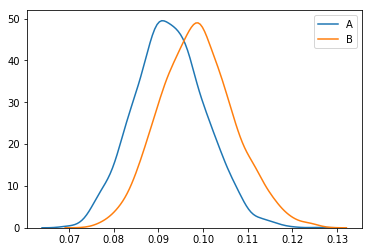

In [75]:
sns.kdeplot(samples_posterior_A, label='A')
sns.kdeplot(samples_posterior_B, label='B')
plt.show()

In [141]:
print ("Probability that site A has higher conversion rates then site B:")
print((samples_posterior_A > samples_posterior_B).mean())
print("\nThis is not very significant considering that if site B and site A were identical webpages and design, \
we would have gotten a probability close to 50%")

Probability that site A has higher conversion rates then site B:
0.30833333333333335

This is not very significant considering that if site B and site A were identical webpages and design, we would have gotten a probability close to 50%


#  Use **Binomial**, as we have two trials (e.g. visitors on two separate months)

In [102]:
from scipy.stats import beta
visitors_to_A = [1300, 1400]
visitors_to_B = [1275, 1150]

conversions_from_A = [120,130]
conversions_from_B = [125, 110]

# beta priors for the binomial likelihood 
alpha_prior = 1
beta_prior = 1

#Posterior probability based on Binomial  likelihood
posterior_A = beta(alpha_prior + (conversions_from_A[0] + conversions_from_A[1]), 
                   beta_prior + (visitors_to_A[0] + visitors_to_A[1]) - (conversions_from_A[0]+conversions_from_A[1]))
posterior_B = beta(alpha_prior + (conversions_from_B[0] + conversions_from_B[1]), 
                   beta_prior + (visitors_to_B[0] + visitors_to_B[1]) - (conversions_from_B[0]+conversions_from_B[1]))

In [103]:
samples = 3000
samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)

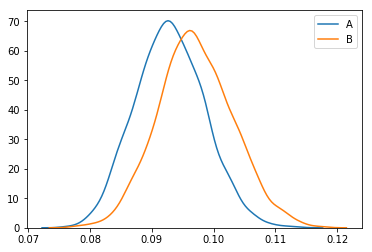

In [106]:
sns.kdeplot(samples_posterior_A, label='A')
sns.kdeplot(samples_posterior_B, label='B')
plt.show()

In [107]:
print ("Probability that site A has higher conversion rates then site B:")
print((samples_posterior_A > samples_posterior_B).mean())

Probability that site A has higher conversion rates then site B:
0.30833333333333335


# Running MCMC with Bernoulli likelihood
* Because the Beta and the Binomial/Bernoulli priors are conjugates we don't need to run MCMC, but if we wanted to, this is how it would look like

In [125]:
# create array with 0's for visitors to website A that didn't sign-up and 1's for visitors that signed-up
site_A = np.zeros(1300-120)
site_A_sign_ups = np.insert(site_A, np.random.randint(low=0,high=120,size=120), 1) 
site_A_sign_ups = site_A_sign_ups.astype(int)

# create array with 0's for visitors to website B that didn't sign-up and 1's for visitors that signed-up
site_B = np.zeros(1275-125)
site_B_sign_ups = np.insert(site_B, np.random.randint(low=0,high=125,size=125), 1) 
site_B_sign_ups = site_B_sign_ups.astype(int)

print(len(site_B_sign_ups))
print(len(site_B_sign_ups[site_B_sign_ups==1]))
print(len(site_A_sign_ups))
print(len(site_A_sign_ups[site_A_sign_ups==1]))

1275
125
1300
120


In [126]:
with pm.Model() as model:
    priors_site_A = pm.Beta('priors_site_A',alpha=1, beta=1)
    priors_site_B = pm.Beta('priors_site_B',alpha=1, beta=1)
    
    delta = pm.Deterministic("delta", priors_site_A - priors_site_B)

    obs_A = pm.Bernoulli('obs_A', p=priors_site_A, observed=site_A_sign_ups)
    obs_B = pm.Bernoulli('obs_B', p=priors_site_B, observed=site_B_sign_ups)
    
    # if we were to use a Binomial likelihood because there were more than 1 trial: 
    # obs_A = pm.Binomial('obs_A', n=#of_trials, p=priors_site_A, observed=site_A_sign_ups)

    trace_bernoulli = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [priors_site_B_logodds__, priors_site_A_logodds__]


In [142]:
pm.summary(trace_bernoulli)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
priors_site_A,0.092867,0.007909,0.000060,0.078049,0.108465,10509.060334,0.999931
priors_site_B,0.098616,0.008330,0.000081,0.082573,0.115134,9986.941531,0.999900
delta,-0.005749,0.011443,0.000104,-0.027620,0.017547,10056.404024,0.999918


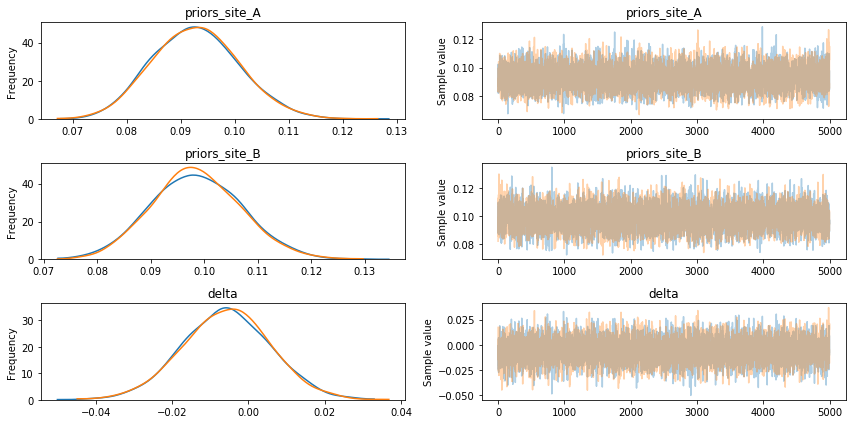

In [128]:
pm.traceplot(trace_bernoulli)
plt.show()

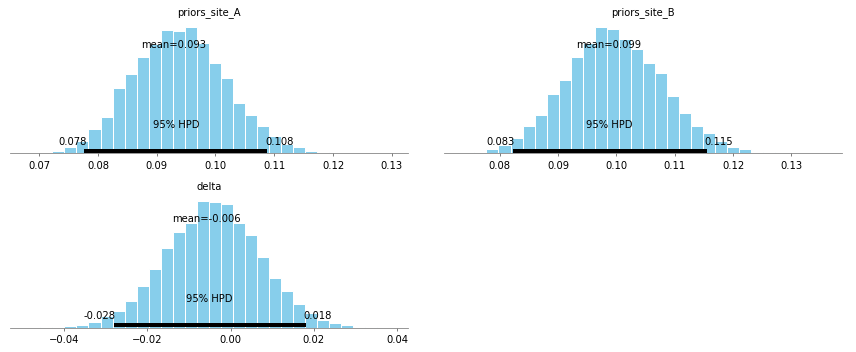

In [129]:
pm.plot_posterior(trace_bernoulli, color='#87ceeb')
plt.show()

In [138]:
print("This is the probability that site_A converstion rate is higher than site B")
print((trace_bernoulli['priors_site_A'] > trace_bernoulli['priors_site_B']).mean())
print("\nSame result, but we use the delta from within the model: "+str((trace_bernoulli['delta']>0).mean()))

This is the probability that site_A converstion rate is higher than site B
0.3051

Same result, but we use the delta from within the model: 0.3051


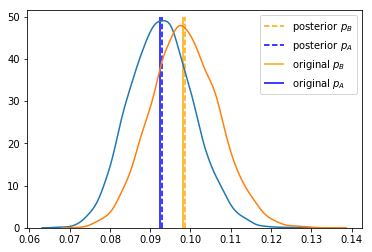

In [139]:
original_conversions_B = site_B_sign_ups[site_B_sign_ups==1].sum() / len(site_B_sign_ups)
original_conversions_A = site_A_sign_ups[site_A_sign_ups==1].sum() / len(site_A_sign_ups)


sns.kdeplot(trace_bernoulli['priors_site_A'])
sns.kdeplot(trace_bernoulli['priors_site_B'])
plt.vlines(np.mean(trace_bernoulli['priors_site_B']), 0, 50, linestyle="--", label="posterior $p_B$", color='orange')
plt.vlines(np.mean(trace_bernoulli['priors_site_A']), 0, 50, linestyle="--", label="posterior $p_A$", color='blue')
plt.vlines((original_conversions_B), 0, 50, linestyle="-", label="original $p_B$", color='orange')
plt.vlines((original_conversions_A), 0, 50, linestyle="-", label="original $p_A$", color='blue')
plt.legend()
plt.show()